## Zadanie 1
Napisz implementacje funkcji loss bazującej na notebooku NeRF, a następnie porównaj loss dla zdjęcia org z zdjęciami b1 ... b5.
Zrób wykresy ilustrujące loss względem każdego z zdjęć

Text(0, 0.5, 'Losses')

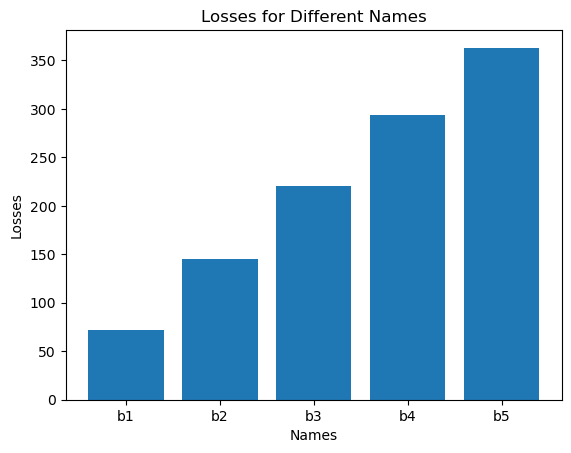

In [9]:
import torch
import matplotlib.pyplot as pyplot
from PIL import Image
from torchvision import transforms

org = Image.open('elza/org.jpg') 
transform = transforms.Compose([transforms.PILToTensor()]) 
org_tensor = transform(org)
losses = []
names = []

def image_loss(t1, t2):
    return torch.nn.functional.mse_loss(t1.float(), t2.float())
for i in range(1,6):
    name = 'b'+ str(i)
    src = 'elza/'+ name +'.jpg'
    copy = Image.open(src) 
    copy_tensor = transform(copy)
    
    mse_loss = image_loss(org_tensor, copy_tensor)
    losses.append(mse_loss)
    names.append(name)
    
fig, ax = pyplot.subplots()
ax.bar(names, losses)
ax.set_title('Losses for Different Names')
ax.set_xlabel('Names')
ax.set_ylabel('Losses')


## Zadanie 2
Napisz i wytrenuj prosty model którego zadaniem bedzie klasyfikacja czy punkt znajduje sie wewnątrz koła jednostkowego czy może poza nim.
Następnie spróbuj użyć Fourier Feature do zmapowania wejścia. 
Poeksperymentuj z różnymi rodzajami transformacji ( parametr L oraz mnożenie przez macierz B)
Wyniki zilustruj wykresami

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch import optim

L = 10  
N = 1000 
E = 500

train = np.random.uniform(-2., 2., (N, 2))
label_train = np.zeros(N)

for i in range(N):
    if np.linalg.norm(train[i]) < 1.0:
        label_train[i] = 1

data_train = torch.tensor(train, dtype=torch.float32)
data_label_train= torch.tensor(label_train, dtype=torch.float32)

test_size = N//6

test = np.random.uniform(-2., 2., (test_size, 2))
label_test = np.zeros(test_size)

for i in range(test_size):
    if np.linalg.norm(test[i]) < 1.0:
        label_test[i] = 1

data_test = torch.tensor(test, dtype=torch.float32)
data_label_test= torch.tensor(label_test, dtype=torch.float32)

In [3]:
class FourierNet(nn.Module):
    def __init__(self, L):
        super(FourierNet, self).__init__()
        self.L = L
        self.B = torch.randn(2*L)  # Change this line
        self.fc1 = nn.Linear(4*L, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        stacked = []
        for i in range(self.L):
            stacked.append(torch.sin(2. * np.pi * x * self.B[2*i]))  # Use element-wise multiplication here
            stacked.append(torch.cos(2. * np.pi * x * self.B[2*i + 1]))  # Use element-wise multiplication here
        x = torch.cat(stacked, dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

class RegularNet(nn.Module):
    def __init__(self):
        super(RegularNet, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

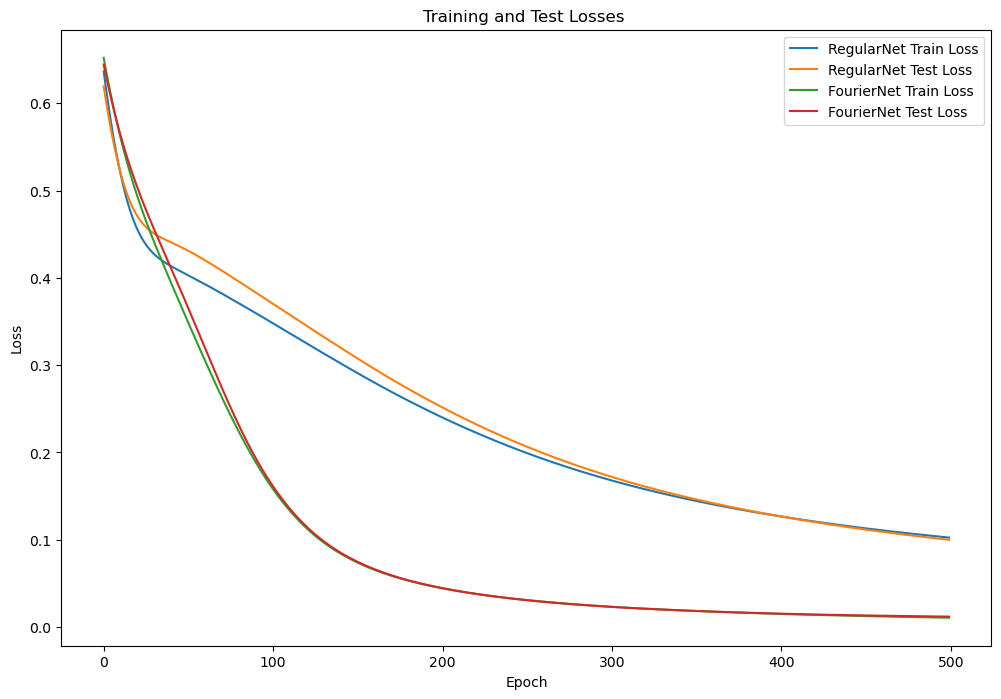

In [4]:
reg = RegularNet()
criterion_reg = torch.nn.BCELoss() 
optimizer_reg = optim.Adam(reg.parameters(), lr=0.001)
train_loss_reg = []
test_loss_reg = []

for epoch in range(E):
    outputs = reg(data_train)
    loss = criterion_reg(outputs.squeeze(), data_label_train)
    train_loss_reg.append(loss.item())
    loss.backward()
    optimizer_reg.step()

    optimizer_reg.zero_grad()
    
    with torch.no_grad():
        outputs_test = reg(data_test)
        loss_test = criterion_reg(outputs_test.squeeze(), data_label_test).item()
        test_loss_reg.append(loss_test)
    

fourier = FourierNet(L)
criterion_fourier = torch.nn.BCELoss() 
optimizer_fourier = optim.Adam(fourier.parameters(), lr=0.001)
train_loss_fourier = []
test_loss_fourier = []

for epoch in range(E):
    outputs = fourier(data_train)
    loss = criterion_fourier(outputs.squeeze(), data_label_train)
    train_loss_fourier.append(loss.item())

    loss.backward()
    optimizer_fourier.step()  

    optimizer_fourier.zero_grad()  
    
    with torch.no_grad():
        outputs_test = fourier(data_test)
        loss_test = criterion_fourier(outputs_test.squeeze(), data_label_test).item()
        test_loss_fourier.append(loss_test)
    

plt.figure(figsize=(12, 8))

plt.plot(train_loss_reg, label='RegularNet Train Loss')
plt.plot(test_loss_reg, label='RegularNet Test Loss')

plt.plot(train_loss_fourier, label='FourierNet Train Loss')
plt.plot(test_loss_fourier, label='FourierNet Test Loss')

plt.title('Training and Test Losses ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Zadanie 3
Napisz i wytrenuj model którego zadaniem bedzie zapamiętanie zdjęcia. 
Zdjęciem które bedzie należy zapamietać jest org_smaller.jpg

Dla modelu bez FF proponuje następującą strukture:
Conv2d( 2,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,3,kernel_size=1,padding=0)
Sigmoid()

In [5]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

org = Image.open('elza/org_smaller.jpg') 
transform = transforms.Compose([transforms.ToTensor()]) 
elza = transform(org).permute(1,2,0)

def tensor_to_numpy(tensor: torch.Tensor) -> np.ndarray:
    tensor = tensor * 256
    tensor[tensor > 255] = 255
    tensor[tensor < 0] = 0
    tensor = tensor.type(torch.uint8).permute(1, 2, 0).cpu().numpy()

    return tensor


/var/folders/5p/l6byzth96sq3xcyy0dt0cvxr0000gn/T/ipykernel_57085/1984803111.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(elza).unsqueeze(0).permute(0, 3, 1, 2).to(device)


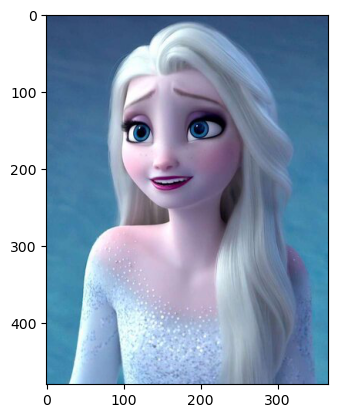

In [6]:
target = torch.tensor(elza).unsqueeze(0).permute(0, 3, 1, 2).to(device)
plt.imshow(tensor_to_numpy(target[0]))
plt.show()

coordsw = np.linspace(0, 1, target.shape[2], endpoint=False)
coordsh = np.linspace(0, 1, target.shape[3], endpoint=False)
xy_grid = np.stack(np.meshgrid(coordsh, coordsw), -1)
xy_grid = torch.tensor(xy_grid).unsqueeze(0).permute(0, 3, 1, 2).float().contiguous().to(device)

Epoch 0, loss = 0.194


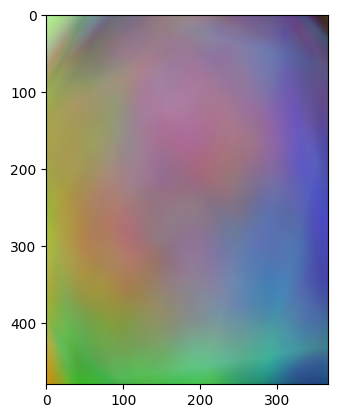

Epoch 100, loss = 0.075


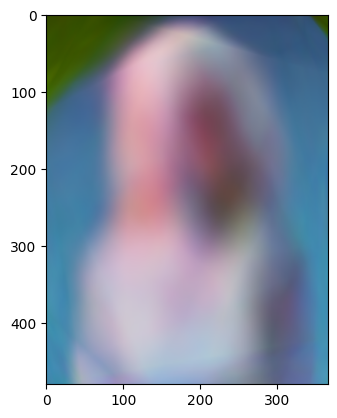

Epoch 200, loss = 0.057


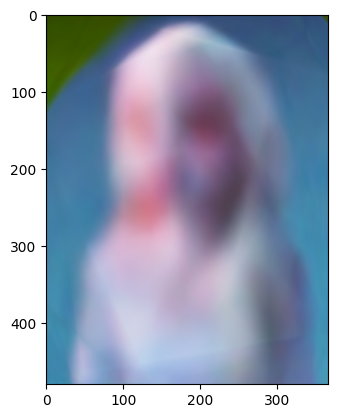

Epoch 300, loss = 0.048


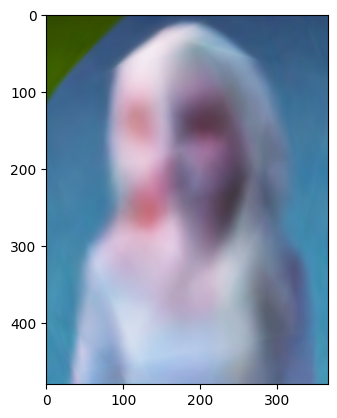

Epoch 400, loss = 0.043


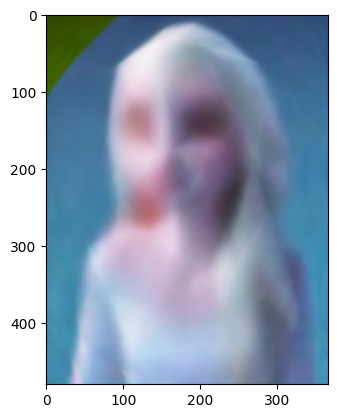

Epoch 500, loss = 0.041


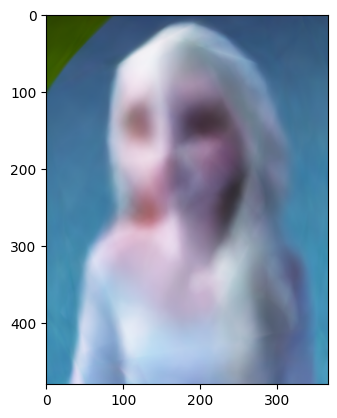

Epoch 600, loss = 0.036


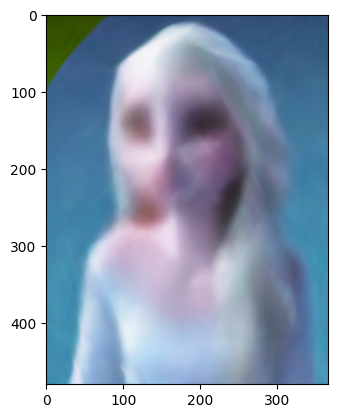

Epoch 700, loss = 0.035


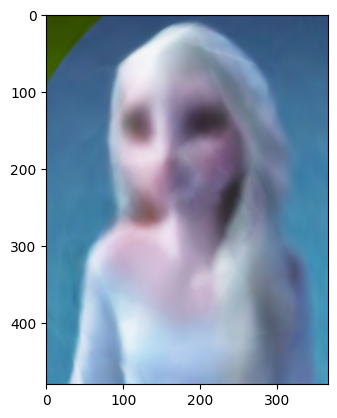

In [7]:
import torch.nn as nn

class ImageRemember(nn.Module):
    def __init__(self):
        super(ImageRemember, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(2, 256, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(256))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(256))

        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(256))

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 3, kernel_size=1, padding=0),
            nn.Sigmoid())

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        return x

imageModel = ImageRemember().to(device)

optimizer = torch.optim.Adam(list(imageModel.parameters()), lr=1e-4)

for epoch in range(400):
    optimizer.zero_grad()

    generated = imageModel(xy_grid)

    loss = image_loss(target, generated)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      plt.imshow(tensor_to_numpy(generated[0]))
      plt.show()

## Zadanie 4
Napisz klasę / funkcje która będzie robić FourierFeature dla wejścia z poprzedniego zadania.

In [10]:
def gaussian_fourier_feature_transform(x, num_input_channels, mapping_size=256, scale=10):
    B = torch.randn((num_input_channels, mapping_size)) * scale
    batches, channels, width, height = x.shape
    
    x = x.permute(0, 2, 3, 1).reshape(batches * width * height, channels)
    x = x @ B.to(x.device)

    x = x.view(batches, width, height, mapping_size)
    x = x.permute(0, 3, 1, 2)

    x = 2 * np.pi * x
    return torch.cat([torch.sin(x), torch.cos(x)], dim=1)

## Zadanie 5
Napisz i wytrenuj model który bedzie miał podobną strukture jak ten z zadania 3, z tą różnicą że wejścia zostaną przetworzone używając Fourier Feature


Model o nastepującej strukturze będzie w zupełności wystarczający: 

Conv2d( 256,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,3,kernel_size=1,padding=0)
Sigmoid()

Epoch 0, loss = 0.067


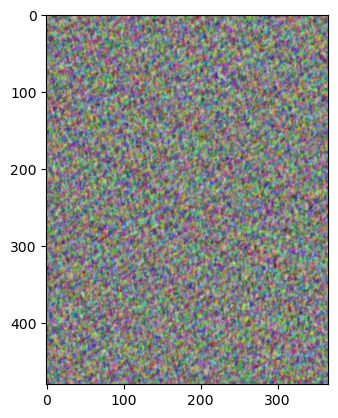

In [ ]:
K_SIZE = 256

class FurierImageRemember(nn.Module):
    def __init__(self):
        super(FurierImageRemember, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(K_SIZE, K_SIZE, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(K_SIZE))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(K_SIZE, K_SIZE, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(K_SIZE))

        self.layer3 = nn.Sequential(
            nn.Conv2d(K_SIZE, K_SIZE, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(K_SIZE))

        self.layer4 = nn.Sequential(
            nn.Conv2d(K_SIZE, 3, kernel_size=1, padding=0),
            nn.Sigmoid())

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        return x

fourier = FurierImageRemember().to(device)

x = gaussian_fourier_feature_transform(xy_grid,2, K_SIZE//2, 30)

optimizer = torch.optim.Adam(list(fourier.parameters()), lr=1e-4)

for epoch in range(600):
    optimizer.zero_grad()

    generated = fourier(x)

    loss = image_loss(target, generated)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      plt.imshow(tensor_to_numpy(generated[0]))
      plt.show()
